## 3. SHAP Analysis

### Introduction

SHAP (SHapley Additive exPlanations) is a unified approach to interpreting machine learning models. It connects game theory with local explanations to explain individual predictions. This notebook will demonstrate how to use SHAP for model interpretability.

### Objectives

1. **Apply SHAP to a Model**: Implement SHAP analysis on a trained machine learning model.
2. **Understand SHAP Values**: Learn what SHAP values are and how they provide insights into model predictions.
3. **Visualize SHAP Values**: Use SHAP visualizations to interpret the impact of features.


In [2]:
# !pip3 -q install gdown
# !gdown -O df1_filtered_modified.csv 1Iwy0f5CF0sUYufygvxjCEMTPScZwTMdL
# !gdown -O df2_filtered_modified.csv 1qid3OAGstzNsdnmlxzW6j1XiRKVp6b_l
# !gdown -O df3_filtered_modified.csv 1LILLLQRFhM2BzQaohUHABOS2E8_wvX-Q
# !gdown -O df5_filtered_modified.csv 1m3sUXmFMNoJo6Y_KGYYCRmCBo8EOgLwc

In [ ]:
import pandas as pd
import joblib
import xgboost

import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.calibration import CalibratedClassifierCV


In [ ]:
def get_calibrated(df:pd.DataFrame, model):
    clf = CalibratedClassifierCV(model) 
    df = df.sample(int(len(df)*0.7))
    y_train = df['class']
    x_train = df.drop(columns=['key', 'class'])
    clf.fit(x_train, y_train)
    return clf

def get_scaled_data(path:str, cols_remove:list=['key', 'class']):
    df = pd.read_csv(path)
    df = df.loc[df['class'].isin([7,5,1,6,4])].copy()
    mask = df['class']!=2
    df=df.loc[mask]
    x = df.drop(columns=cols_remove).values
    #minmax scaling
    min_max_scaler = preprocessing.MinMaxScaler() 
    x_scaled = min_max_scaler.fit_transform(x)
    target_cols = [col for col in list(df.columns) if col not in cols_remove]
    df.loc[:, target_cols] = x_scaled
    return df, min_max_scaler

dict_normal_names = {7: "Pine", 
        5:"Aspen",
        1:"Birch",
        6:"Silver fir",
        4:'Larch'}

### 1. kNN model - SHAP Analysis

In [3]:
loaded_model = joblib.load('../models/kNN_df1_filtered_modified.joblib')
df, scaler = get_scaled_data(path= './datasets/df1_filtered_modified.csv')
sample = df.sample(200)
X = sample.drop(columns=['key','class'])
y = sample['class']
explainer = shap.KernelExplainer(loaded_model.predict_proba,X) #shap.kmeans(X_train, 50))
explanation = explainer(X)
shap_values = explanation.values


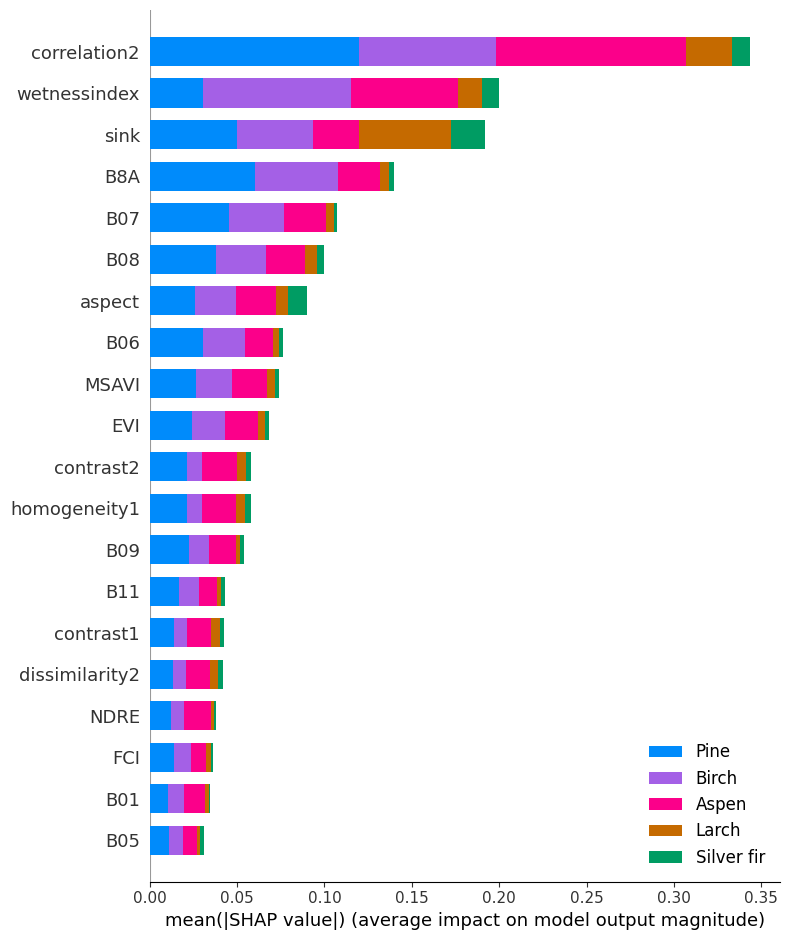

In [ ]:
names = []
for class_id in loaded_model.classes_:
    names.append(dict_normal_names[class_id])
original_shape = shap_values.shape
fig, ax = plt.subplots(1,1)
shap_values_transposed = shap_values.transpose(2, 0, 1)
shap.summary_plot(list(shap_values_transposed), features=X,
                   class_names=names, plot_type='bar', show=False)
plt.savefig('./shap-knn.png', dpi=300)

### 2. RF model - SHAP

In [ ]:
loaded_model = joblib.load('../models/RandomForest_df3_filtered_modified.joblib')
df, scaler = get_scaled_data(path= './datasets/df3_filtered_modified.csv')
X = df.drop(columns=['key','class'])
y = df['class']
pred = loaded_model.predict(X)
explainer = shap.TreeExplainer(loaded_model)
explanation = explainer(X)
shap_values = explanation.values

### 3. SVC model - SHAP

In [ ]:
loaded_model = joblib.load('./models/SVC_df5_filtered_modified.joblib')
df, scaler = get_scaled_data(path= './datasets/df5_filtered_modified.csv')
loaded_model = get_calibrated(df,loaded_model)
sample = df.sample(100)
X = sample.drop(columns=['key','class'])
y = sample['class']
loaded_model = joblib.load('./models/SVC_df5_filtered_modified.joblib')

explainer = shap.KernelExplainer(loaded_model._predict_proba_lr, X)
explanation = explainer(X)


/Users/mikhailgasanov/geo/lib/python3.12/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mikhailgasanov/geo/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/mikhailgasanov/geo/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mikhailgasanov/geo/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1

  0%|          | 0/100 [00:00<?, ?it/s]

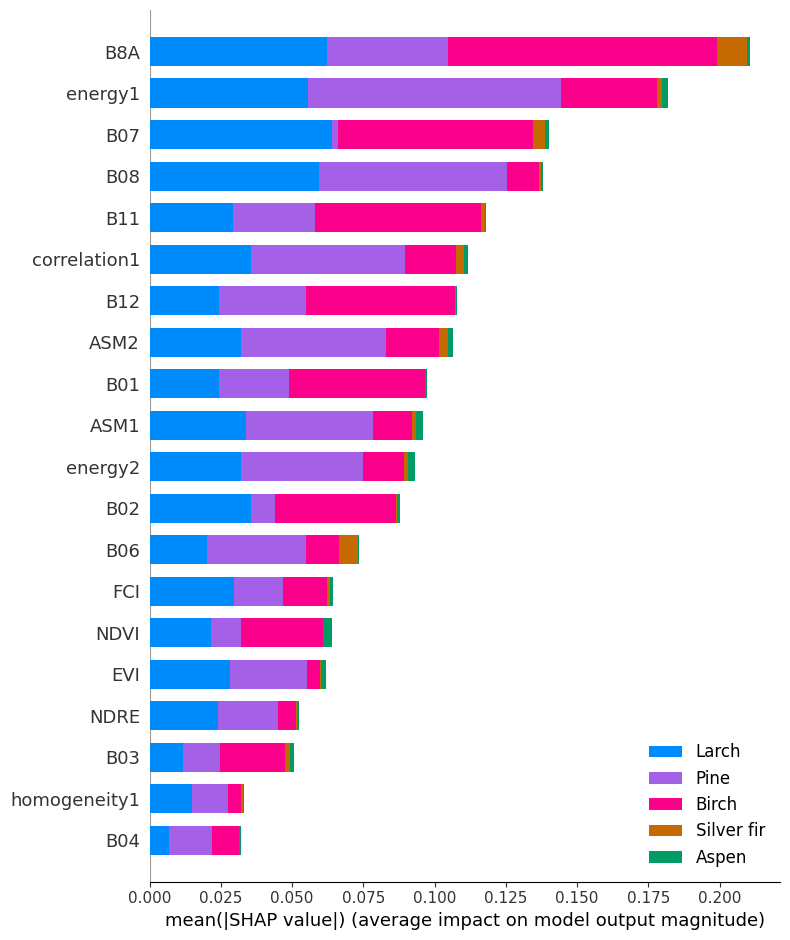

In [ ]:
names = []
for class_id in loaded_model.classes_:
    names.append(dict_normal_names[class_id])
original_shape = shap_values.shape
fig, ax = plt.subplots(1,1)
shap_values = explanation.values
shap_values_transposed = shap_values.transpose(2, 0, 1)
shap.summary_plot(list(shap_values_transposed), features=X, class_names=names, plot_type='bar', show=False)
plt.savefig('./shap-svc.png', dpi=300)

## End